

Laboratorio 3 - Modelo de Regresión Lineal

By Cristian Laynez - 201281

Se provee un dataset donde se muestran los precios de casas en King Country, Seattle. 

Este conjunto incluye los precios de las casas vendidas entre mayo 2014 y mayo 2015. 

El objetivo de este laboratorio es definir un modelo de regresion lineal donde se puedad verla relacion entre precio 
y pies cuadrasa del espacio habitable interior de los apartementos.

In [1]:
# Importar todas las librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
# --> Leer la data proporcionada
f = open('kc_house_data.csv', 'r')
reader = csv.reader(f)
header = next(reader, None)

# Se guardara la data en un diccionario
data = {}
for h in header:
    data[h] = []

# Se guardaran todos los valores
for row in reader:
    control = 0
    for h, v in zip(header, row):        
        d = float(v) if control >= 2 else v
        temp = [d]
        data[h].append(temp)
        control += 1


In [3]:
# Imprimir todos los headers que se encontraron
print(header)

['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [4]:
# Definir funcion lambda de costo
cost = lambda X, y, t : ((X @ t - y) ** 2).sum() / len(y)

# Definir funcion lambda de gradiente
grad = lambda X, y, t : 2 * X.T @ (X @ t - y) / len(y)

# Definir funcion lambda de normalizacion que nos ayudara a tener un sistema de regresion lineal mas optimo
norm = lambda v : np.sqrt((v ** 2).sum())

# ! Referencia y creditos al ejemplo proveido en clase :)

In [5]:
# --> Ajustando sistema de regresion lineal
def linear_regression(X, y ,t, cost, grad, a=0.1, n=100, on_step=None):
    costs = []
    for _ in range(n):
        nabla = grad(X, y, t)
        t -= a * nabla
        costs.append(norm(nabla))

        if on_step:
            on_step(t)

    return t, costs

# ! Referencia y creditos al ejemplo proveido en clase :)

In [6]:
DATASET_SET_SIZE = len(data['id'])
DATASET_SPARSE_RATIO = 50
DATASET_X_LIM = 100

In [35]:
# --> Obtener datos para mostrar la siguiente relacion:
# * precio y pies cuadrados del espacio habitable interior (price - sqft_living).
array_living = np.array(data['sqft_living'])
array_price = np.array(data['price'])
X = array_price.reshape((DATASET_SET_SIZE, 1))
Xr = np.hstack((
    np.ones((DATASET_SET_SIZE, 1)),
    array_living.reshape((DATASET_SET_SIZE, 1))
))
y = 3 + 2 * X + array_living.reshape((DATASET_SET_SIZE, 1)) * DATASET_SPARSE_RATIO

to = np.random.rand(Xr.shape[1], 1)
xmr = np.hstack((np.ones((X.shape[0], 1)), X))
theta = np.linalg.inv(xmr.T @ xmr) @ xmr.T @ array_living # array_living = y
print(f"theta: {theta} and {theta[0][0]} and {theta[1][0]}")

# -> Utilizar la implementacion vectorial del algoritmo de regresion lineal
tf, costs = linear_regression(
    Xr, 
    y, 
    theta, 
    cost, 
    grad, 
    a=0.00000001, 
    n=200,
)

print(f"Tf: {tf}")

# Preparar las variables para la prediccion
xm = np.array([[0], [DATASET_X_LIM]])
print(f"xm: {xm}")
xmr = np.hstack((
    np.ones((2, 1)),
    xm
))
ym = xmr @ tf
print(f"xmr: {xmr}")
print(f"ym: {ym}")

theta: [[1.13135439e+03]
 [1.75627878e-03]] and 1131.3543927134137 and 0.0017562787815594398
Tf: [[1131.52840576]
 [ 575.7243228 ]]
xm: [[  0]
 [100]]
xmr: [[  1.   0.]
 [  1. 100.]]
ym: [[ 1131.52840576]
 [58703.96068536]]


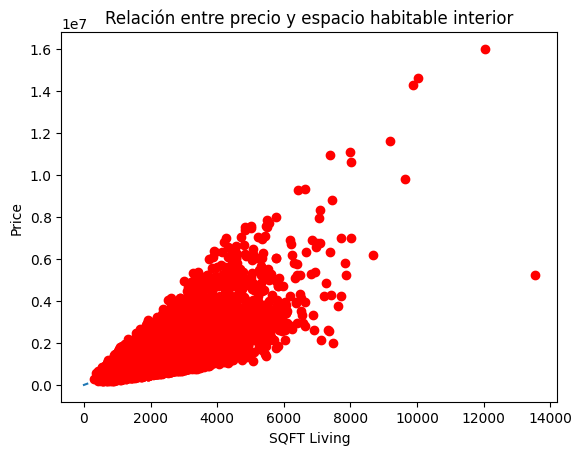

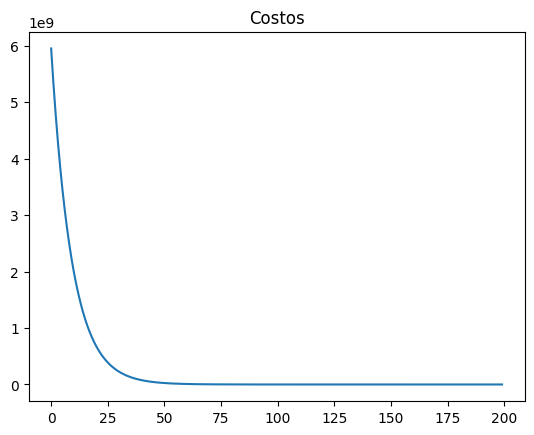

In [38]:
# Se graficara el resultado del modelo de regresion lineal

# ! Graficar modelo de regresion lineal
plt.plot(Xr[:, 1], y, 'ro') # datos
plt.plot(xm, ym) # regresion lineal
plt.title("Relación entre precio y espacio habitable interior")
# price - sqft_living
plt.xlabel('SQFT Living')
plt.ylabel('Price')
plt.show()

# ! Graficar costos
# Para visualizar que tan bueno es nuestro modelo de regresion lineal
plt.plot(costs)
plt.title("Costos")
plt.show()

--> Análisis sobre los hallazgos

Como se podra observar en la grárfica de "Relación entre precio y espacio habitable interior" se puede apreciar una dispersión entre precio y espacio habitable.

En donde se da a entender que mientras mas espacio exista el precio de este ira en aumento. 

La regresion lineal nos demuestra que si estan muy relacionados estas cualidades.